In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [14]:
PATH = "../data/census/rent/"
df_21 = pd.read_csv(PATH + "median_rent_17to21.csv")
df_16 = pd.read_csv(PATH + "median_rent_12to16.csv")

In [15]:
# White
# Black or African American
# American Indian and Alaska Native
# Asian
# Native Hawaiian and Other Pacific Islander
# Some Other Race alone

def fix_labels(df):
    df["Label (Grouping)"] = df["Label (Grouping)"].map(lambda x: x.lstrip('\xa0'))

    
def get_topics_idcs(df):
    return df[df.isna().any(axis=1)].index


def get_topics(df):
    # Get IDCS of Grouping Rows
    idcs = get_topics_idcs(df)
    idx_pairs = [(idcs[i], idcs[i+1]) if i < (len(idcs) - 1) else (idcs[i],) for i in range(len(idcs))]
    
    # Format the labels
    fix_labels(df)
    
    labels = df.iloc[idcs]["Label (Grouping)"].values
    return list(zip(idx_pairs, labels))


def get_all_sub_dfs(df):
    
    all_subtopics = get_topics(df)
    topic = {}
    subtopics = []
    
    for subtopic_idcs, subtopic in all_subtopics:
        
        if len(subtopic_idcs) == 2:
            topic[subtopic] = df.iloc[subtopic_idcs[0] + 1:subtopic_idcs[1]]
        else:
            topic[subtopic] = df.iloc[subtopic_idcs[0] + 1:]
            
        # Check whether the first row contains values of interest
        if not df.iloc[0].isna().any():
            topic[subtopic].loc[-1] = df.loc[0]                # adding a row
            topic[subtopic].index = topic[subtopic].index + 1  # shifting index
            topic[subtopic] = topic[subtopic].sort_index()     # sorting by index

            
        topic[subtopic] = topic[subtopic].rename(columns={"Label (Grouping)": subtopic})
        topic[subtopic].set_index(subtopic, inplace=True)
        subtopics.append(subtopic)
            
    subtopics = '\n'.join([subtopic for subtopic in subtopics])
    print("The subtopics are:")
    print(subtopics)
    
    return topic


def convert_series_to_int(series):
    new_series = [int("".join(x.split(","))) if type(x) == str else x for x in series.values]
    return np.asarray(new_series)


In [16]:
fix_labels(df_21)
fix_labels(df_16)

dict_21 = get_all_sub_dfs(df_21)
dict_16 = get_all_sub_dfs(df_16)

The subtopics are:

The subtopics are:



In [17]:
def fix_indices(df):
    df.index = df["Label (Grouping)"].values
    df.drop(columns="Label (Grouping)", inplace=True)
    

In [18]:
fix_indices(df_21)
fix_indices(df_16)

In [19]:
curr_list = [df_21, df_16]

for idx in range(len(curr_list)):
    
    # Preprocess data
    all_columns = []
    for column in curr_list[idx].iloc[:-1].columns:
        if "Percent" in column:
            all_columns.append(column)

    curr_list[idx].drop(columns=all_columns, inplace=True)
    curr_list[idx] = curr_list[idx].apply(convert_series_to_int)

    curr_list[idx].columns = [x[1].split(", District")[0][1:] + " - " + x[-1].split("!!")[1] for x in curr_list[idx].columns.str.split("Census")]
    curr_list[idx] = curr_list[idx].iloc[:]

In [20]:
# What would be good to look at?

# 1. Percentage of Tract that is below poverty level
# 2. Percentage of which race makes up which portion of Below poverty level
# 3. Percentage of how many of a race are below poverty level

curr_list[0]

,Tract 64 - Estimate,Tract 102.01 - Estimate,Tract 102.02 - Estimate,Tract 105 - Estimate,Tract 110.01 - Estimate,Tract 110.02 - Estimate
Median contract rent,740,2228,1799,1608,1960,1832


In [21]:
tracts = ["Tract 64", "Tract 102.01", "Tract 102.02", "Tract 105", "Tract 110.01", "Tract 110.02"]
tract_df = curr_list[-1].loc[:, curr_list[-1].columns.str.contains(tracts[0])]
tract_df

,Tract 64 - Estimate
Median contract rent,408


In [67]:
# Get appropriate columns for the data frame
# ------------------------------------------

# ONLY EXECUTE THIS WHEN THE VARIABLE IS ABOUT RACE
labels = np.asarray([x.split(" alone")[0] for x in list(curr_list[0].index)])
new_columns = labels[1:]
new_columns[-1] = "Mixed race"

In [25]:
tract_df

,Tract 64 - Estimate
Median contract rent,408


In [26]:

# Get data
# --------
tracts = ["Tract 64", "Tract 105", "Tract 102.01", "Tract 102.02", "Tract 110.01", "Tract 110.02"]
years = ["2021", "2016"]


tract_dict = {}
for tract in tracts:

    year_dict = {}
    
    for idx, year in enumerate(years):
        
        try:

            tract_df = curr_list[idx].loc[:, curr_list[idx].columns.str.contains(tract)]
            values = tract_df.iloc[0][0]

            # poverty_by_tract[tract] = all_values
            year_dict[year] = values
            
        except IndexError:
            continue
            
    # reverse the dictionary to stay in chronological order
    tract_dict[tract] = dict(reversed(list(year_dict.items())))
    

In [27]:
tract_dict["Tract 64"]

{'2016': 408, '2021': 740}

In [30]:
pd.DataFrame.from_dict(tract_dict["Tract 64"], orient="index", columns=["Median Rent"])

,Median Rent
2016,408
2021,740


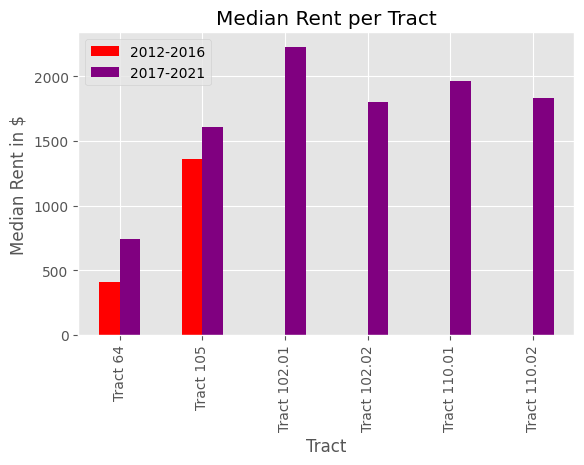

In [38]:
pd.DataFrame.from_dict(tract_dict).T.plot(color=["red", "purple"], kind="bar")
plt.gcf().subplots_adjust(bottom=0.25)
plt.title("Median Rent per Tract")
plt.xlabel("Tract")
plt.ylabel("Median Rent in $")
plt.legend(["2012-2016", "2017-2021"], loc="best")
plt.savefig(f"../plots/rent/all_tracts.png")


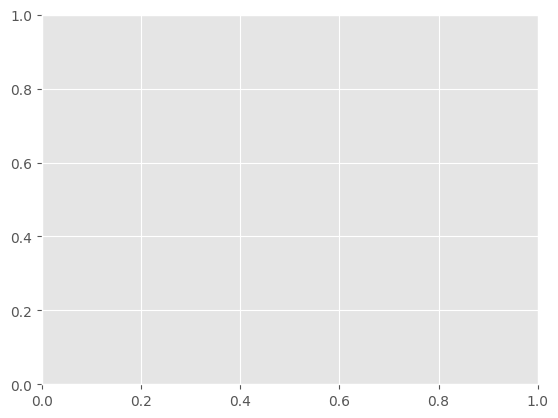

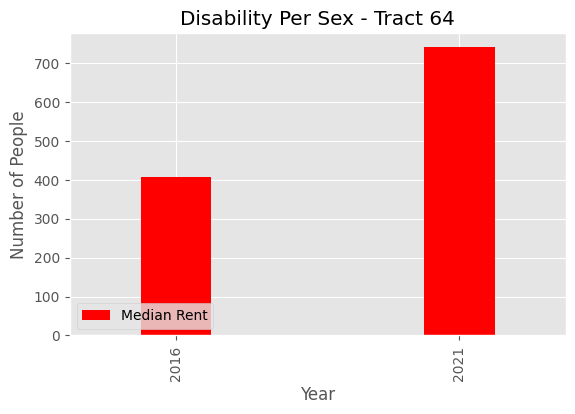

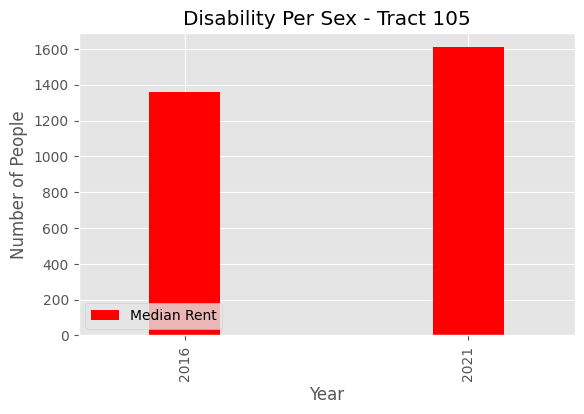

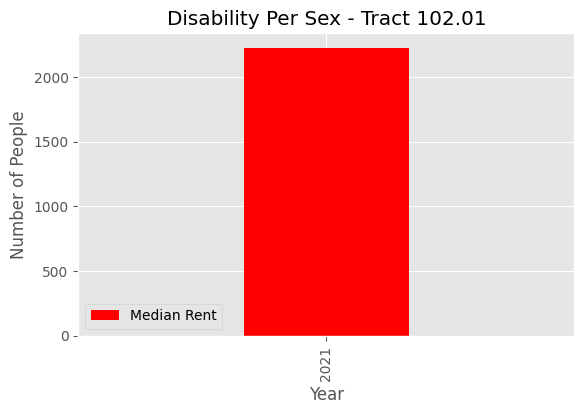

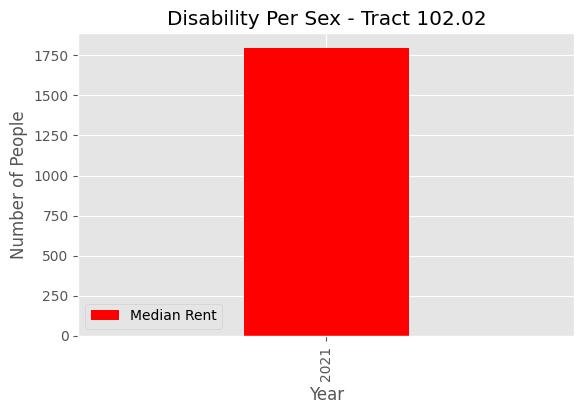

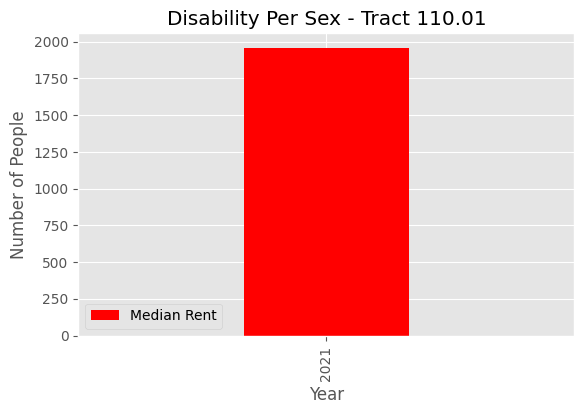

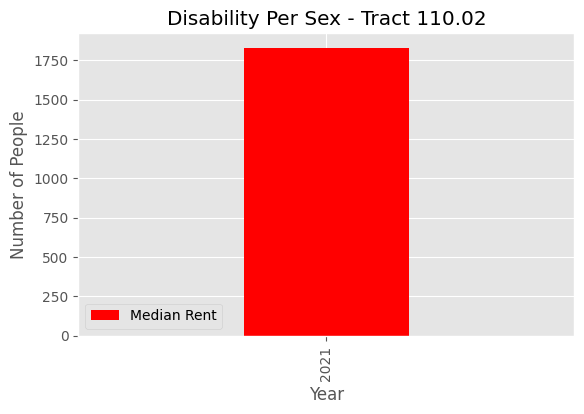

In [31]:
# Plot data
# ---------
import matplotlib
matplotlib.style.use('ggplot')
fig, ax = plt.subplots()

for tract in tracts:
    fig, ax = plt.subplots()
    df_for_plotting = pd.DataFrame.from_dict(tract_dict[tract], orient="index", columns=["Median Rent"])
    # drop empty columns

    df_for_plotting.plot(color=["red", "purple"], 
                         kind="bar", stacked=True, title=f"Disability Per Sex - {tract}", ax=ax, position=0.5, width=0.25)

    plt.gcf().subplots_adjust(bottom=0.25)
    plt.xlabel("Year")
    plt.ylabel("Number of People")
    plt.legend(loc="lower left")
    plt.savefig(f"../plots/disability/per_sex/{tract}.png")


In [99]:
# 1. Percentage of Tract that is below poverty level


# Get the data
# ------------
tracts = ["Tract 64", "Tract 105", "Tract 102.01", "Tract 102.02", "Tract 110.01", "Tract 110.02"]
years = ["2021", "2020", "2019", "2018", "2017", "2016", "2015"]


poverty_by_tract = {}
for tract in tracts:

    poverty_by_year = {}
    
    for idx, year in enumerate(years):
        
        try:
            tract_df = poverty_race_years[idx].loc[:, poverty_race_years[idx].columns.str.contains(tract)]

            # Get total number of people below and above poverty level
            above_poverty = tract_df.iloc[0].values[0] - tract_df.iloc[0].values[1]
            all_values = np.append(tract_df.iloc[1:, 1].values.sum(), above_poverty)

            # poverty_by_tract[tract] = all_values
            poverty_by_year[year] = all_values
        except IndexError:
            continue
            
    # reverse the dictionary to stay in chronological order
    poverty_by_tract[tract] = dict(reversed(list(poverty_by_year.items())))

In [100]:
poverty_by_tract["Tract 64"]

{'2014': array([1866, 1053]),
 '2015': array([ 943, 1187]),
 '2016': array([1100, 1355]),
 '2017': array([1229, 1259]),
 '2018': array([ 898, 1671]),
 '2019': array([1007, 1827]),
 '2020': array([ 957, 1504]),
 '2021': array([1046, 1372])}

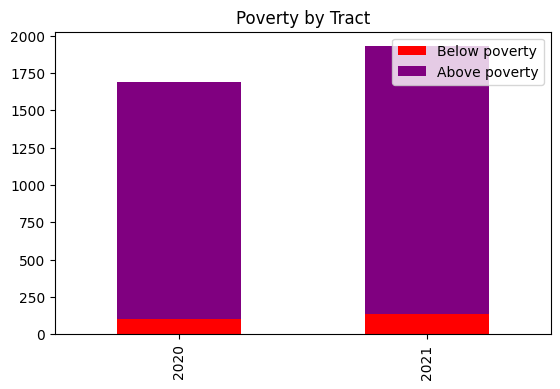

In [109]:
# Plot the data
# -------------
df_for_plotting = pd.DataFrame.from_dict(poverty_by_tract["Tract 102.02"], orient="index", columns=["Below poverty", "Above poverty"])
df_for_plotting.plot(color=["red", "purple"], kind="bar", stacked=True, title="Poverty by Tract")
plt.gcf().subplots_adjust(bottom=0.25)

plt.savefig("../plots/race/poverty_tract_102_2_per_year.png")

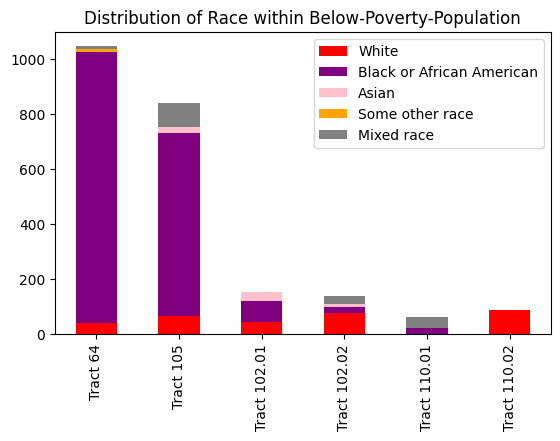

In [306]:
# 2. Percentage of which race makes up which portion of Below Poverty level


# Get appropriate columns for the data frame
# ------------------------------------------
race_labels = np.asarray([x.split(" alone")[0] for x in list(poverty_race.index)])
new_columns = race_labels[1:]
new_columns[-1] = "Mixed race"


# Get data
# --------
tracts = ["Tract 64", "Tract 105", "Tract 102.01", "Tract 102.02", "Tract 110.01", "Tract 110.02"]

poverty_by_tract = {}

for tract in tracts:
    tract_df = poverty_race.loc[:, poverty_race.columns.str.contains(tract)]
    values = tract_df.iloc[1:, 1].values
    
    poverty_by_tract[tract] = values
    
    
# Plot data
# ---------
df_for_plotting = pd.DataFrame.from_dict(poverty_by_tract, orient="index", columns=new_columns)

# drop empty columns
df_for_plotting = df_for_plotting.drop(["American Indian and Alaska Native", "Native Hawaiian and Other Pacific Islander"], axis=1)
df_for_plotting.plot(color=["red", "purple", "pink", "orange", "gray"], 
                     kind="bar", stacked=True, title="Distribution of Race within Below-Poverty-Population")

plt.gcf().subplots_adjust(bottom=0.25)
plt.savefig("../plots/race/distribution_of_race_below_poverty_per_tract.png")

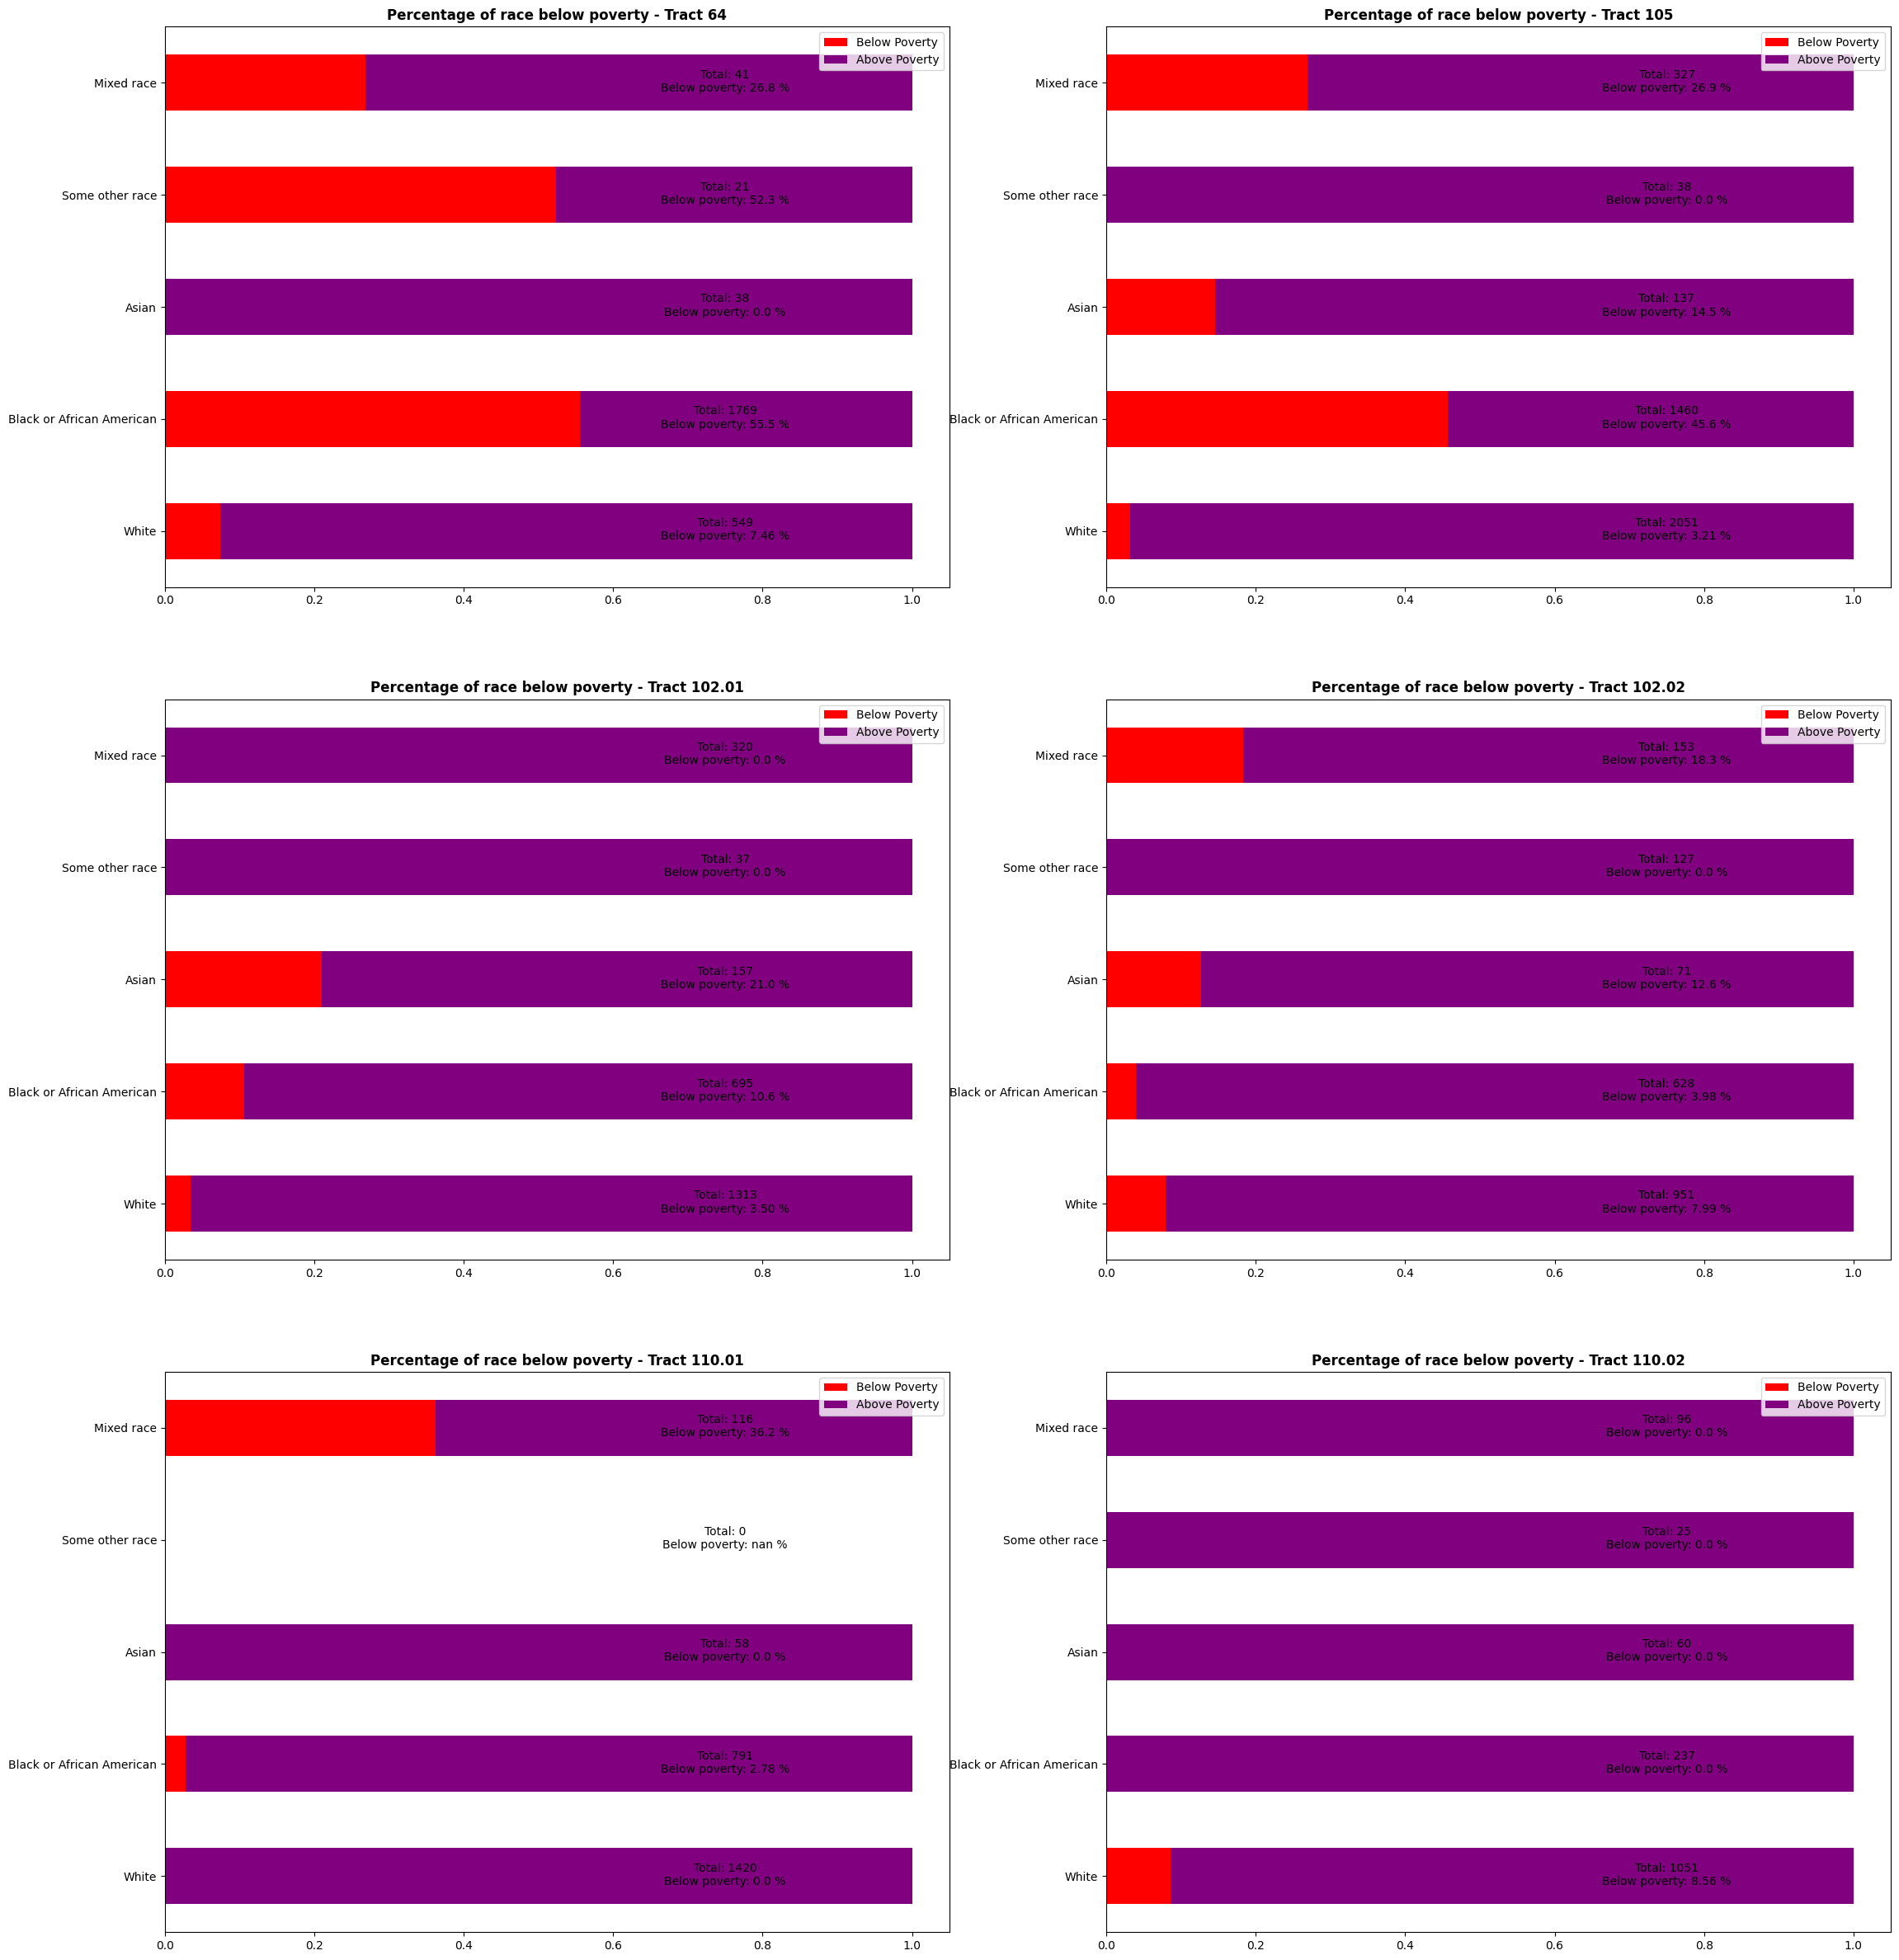

In [332]:
# 3. Percentage of how many of a race are below poverty level

# Get data
# --------
tracts = ["Tract 64", "Tract 105", "Tract 102.01", "Tract 102.02", "Tract 110.01", "Tract 110.02"]

poverty_per_race_per_tract = {}
total_per_tract = {}

for tract in tracts:
    tract_df = poverty_race.iloc[1:, poverty_race.columns.str.contains(tract)]
    tract_df = tract_df.drop(["American Indian and Alaska Native alone", "Native Hawaiian and Other Pacific Islander alone"])
    
    tract_df.index = np.asarray([x.split(" alone")[0] for x in list(tract_df.index)])
    labels = list(tract_df.index)
    labels[-1] = "Mixed race"
    
    # Total number of people of race within tract
    total_per_tract[tract] = tract_df.iloc[:, 0].values
    
    # Percentage of Poverty Within Race
    # e.g. 55% of Black Population within tract is below poverty level
    poverty_within_race_percent = tract_df.apply(lambda x: x[1] / x[0], axis=1).values
    poverty_per_race_per_tract[tract] = pd.DataFrame.from_dict({"Race": labels,
                                                                "Below Poverty": poverty_within_race_percent,
                                                                "Above Poverty": np.ones(5) - poverty_within_race_percent})
    poverty_per_race_per_tract[tract] = poverty_per_race_per_tract[tract].set_index("Race")
    
    
    
# Plot data
# ---------

# Helper Functions
def addlabels(rects, labels, ax):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(height + 0.25, rect.get_y() + 0.15, label, ha="center", va="bottom")
        
def convert_to_percent(values):
    percentages = [str(x * 100)[:4] + " %" for x in values]
    return percentages

def add_percent_to_labels(labels, values):
    percentages = convert_to_percent(values)
    new_labels = []
    for idx in range(len(percentages)):
        new_labels.append(
            labels[idx] + "\n" + "Below poverty: " + percentages[idx]
        )
    return new_labels

    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(27, 30))
row_idcs = [0, 0, 1, 1, 2, 2]

for idx, tract in enumerate(tracts):
    row_idx = row_idcs[idx]
    column_idx = idx % 2    
    
    curr_ax = axes[row_idx, column_idx]
    poverty_per_race_per_tract[tract].plot(color=["red", "purple"], 
                                                kind="barh", stacked=True, ax=curr_ax)
    rects = curr_ax.patches
    
    # Get the total number of people of race in tract
    labels = ["Total: "+ str(x) for x in total_per_tract[tract]]
    # Get percentage of people below poverty
    percentages = poverty_per_race_per_tract[tract]["Below Poverty"].values
    labels = add_percent_to_labels(labels, percentages)

    curr_ax.set_title("Percentage of race below poverty - " + tract, fontweight="bold")
    curr_ax.set_ylabel('')
    addlabels(rects, labels, curr_ax)


plt.savefig("../plots/race/percentage_of_race_below_poverty.png")
plt.savefig("../plots/race/percentage_of_race_below_poverty.pdf")

In [312]:
ls = poverty_per_race_per_tract["Tract 64"]["Below Poverty"].values

In [326]:
def convert_to_percent(values):
    percentages = [str(x * 100)[:4] + " %" for x in values]
    return percentages

In [328]:
convert_to_percent(ls)

['7.46 %', '55.5 %', '0.0 %', '52.3 %', '26.8 %']

In [329]:
labels

['Total: 1051', 'Total: 237', 'Total: 60', 'Total: 25', 'Total: 96']

In [330]:
def add_percent_to_labels(labels, values):
    percentages = convert_to_percent(values)
    new_labels = []
    for idx in range(len(percentages)):
        new_labels.append(
            labels[idx] + "\n" + "Below poverty: " + percentages[idx]
        )
        
    return new_labels

In [331]:
add_percent_to_labels(labels, ls)

['Total: 1051\nBelow poverty: 7.46 %',
 'Total: 237\nBelow poverty: 55.5 %',
 'Total: 60\nBelow poverty: 0.0 %',
 'Total: 25\nBelow poverty: 52.3 %',
 'Total: 96\nBelow poverty: 26.8 %']